The objective of this analysis is to identify cross selling opportunity, which will further help in bundling of products, creating offers and site layout design

Market basket analysis: Market basket analysis is a method to gain insights into granular behavior of customers. This is helpful in devising strategies which uncovers deeper understanding of purchase decisions taken by the customers. This is interesting as a lot of times even the customer will be unaware of such biases or trends in their purchasing behavior.

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *
%matplotlib inline

In [2]:
df = pd.read_csv('grocery.csv')

In [3]:
df.head()

Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                    NaN         0                 0               NaN   
1                    NaN         0                 0               NaN   
2                    NaN         0                 0               NaN   
3                    NaN         0                 0               NaN   
4                    NaN         0                 0               NaN   

   baby cosmetics  baby food  bags  baking powder  bathroom cleaner  beef  \
0             NaN        NaN   NaN            NaN               NaN   NaN   
1             NaN        NaN   NaN            NaN               NaN   NaN   
2             NaN        NaN   NaN            NaN               NaN   NaN   
3             NaN        NaN   NaN            NaN               NaN   NaN   
4             NaN        NaN   NaN            NaN               NaN   NaN   

     ...     turkey  vinegar  waffles  whipped/sour cream  whisky  \
0    ...        NaN      NaN      NaN                 NaN     NaN   
1    ...        NaN      NaN      NaN                 NaN     NaN   
2    ...        NaN      NaN      NaN                 NaN     NaN   
3    ...        NaN      NaN      NaN                 NaN     NaN   
4    ...        NaN      NaN      NaN                 NaN     NaN   

   white bread  white wine  whole milk  yogurt  zwieback  
0            0         NaN           0       0       NaN  
1            0         NaN           0       1       NaN  
2            0         NaN           1       0       NaN  
3            0         NaN           0       1       NaN  
4            0         NaN           1       0       NaN  

[5 rows x 169 columns]

In [4]:
df.shape

(9835, 169)

In [5]:
total_item_count = sum(df.sum())

In [6]:
total_item_count

43367.0

In [7]:
item_summary = df.sum().sort_values(ascending=False).reset_index()

In [8]:
item_summary.head()

index       0
0        whole milk  2513.0
1  other vegetables  1903.0
2        rolls/buns  1809.0
3              soda  1715.0
4            yogurt  1372.0

In [9]:
item_summary.rename(columns={'index':'item_name',0:'item_count'}, inplace=True)

In [10]:
item_summary.head()

item_name  item_count
0        whole milk      2513.0
1  other vegetables      1903.0
2        rolls/buns      1809.0
3              soda      1715.0
4            yogurt      1372.0

Text(0.5, 1.0, 'Item sales distribution')

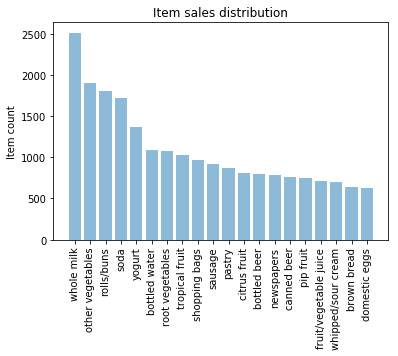

In [11]:
objects = (list(item_summary['item_name'].head(n=20)))
y_pos = np.arange(len(objects))
performance = list(item_summary['item_count'].head(n=20))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Item sales distribution')

### How much percentage of total sale explained by these 20 items alone?

In [12]:
item_summary['item_perc'] = item_summary['item_count']/total_item_count
item_summary['total_perc'] = item_summary.item_perc.cumsum()
item_summary.head(20)

item_name  item_count  item_perc  total_perc
0              whole milk      2513.0   0.057947    0.057947
1        other vegetables      1903.0   0.043881    0.101829
2              rolls/buns      1809.0   0.041714    0.143542
3                    soda      1715.0   0.039546    0.183089
4                  yogurt      1372.0   0.031637    0.214725
5           bottled water      1087.0   0.025065    0.239791
6         root vegetables      1072.0   0.024719    0.264510
7          tropical fruit      1032.0   0.023797    0.288307
8           shopping bags       969.0   0.022344    0.310651
9                 sausage       924.0   0.021307    0.331957
10                 pastry       875.0   0.020177    0.352134
11           citrus fruit       814.0   0.018770    0.370904
12           bottled beer       792.0   0.018263    0.389167
13             newspapers       785.0   0.018101    0.407268
14            canned beer       764.0   0.017617    0.424885
15              pip fruit       744.0   0.017156    0.442041
16  fruit/vegetable juice       711.0   0.016395    0.458436
17     whipped/sour cream       705.0   0.016257    0.474693
18            brown bread       638.0   0.014712    0.489404
19          domestic eggs       624.0   0.014389    0.503793

Top 20 items are responsible for over 50% of sales

### Orange Table Data Structure

In [13]:
input_assoc_rules = df
domain_grocery = Domain([DiscreteVariable.make(name=item, values=['0', '1']) for item in
input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery,
X=input_assoc_rules.values,Y= None)

### Prune Dataset

We saw in the earlier section how only a handful of items are
responsible for bulk of our sales so we want to prune our dataset to reflect this information. For this we have
created a function prune_dataset (check out the notebook), which will help us reduce the size of our dataset
based on our requirements. The function can be used for performing two types of pruning:

• Pruning based on percentage of total sales: The parameter total_sales_perc will
help us select the number of items that will explain the required percentage of sales.
The default value is 50% or 0.5.

• Pruning based on ranks of items: Another way to perform the pruning is to specify
the starting and the ending rank of the items for which we want to prune our dataset.

we will only look for transactions which have at least two items, as transactions with only
one item are counter to the whole concept of association rule-mining.

In [14]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, start_item = None, end_item = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',item_count.columns[1]:'item_count'}, inplace=True)
    if not start_item and not end_item: 
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]

In [15]:
output_df, item_counts = prune_dataset(input_df=df, length_trans=2,total_sales_perc=0.4)


In [16]:
output_df.shape

(4585, 13)

In [17]:
output_df.columns

Index(['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt',
       'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags',
       'sausage', 'pastry', 'citrus fruit', 'bottled beer'],
      dtype='object')

In [18]:
output_df.head()

whole milk  other vegetables  rolls/buns  soda  yogurt  bottled water  \
1            0                 0           0   NaN       1              0   
4            1                 1           0   NaN       0              0   
5            1                 0           0   NaN       1              0   
7            0                 1           1   NaN       0              0   
10           0                 1           0   NaN       0              1   

    root vegetables  tropical fruit  shopping bags  sausage  pastry  \
1               NaN               1            NaN      NaN     NaN   
4               NaN               0            NaN      NaN     NaN   
5               NaN               0            NaN      NaN     NaN   
7               NaN               0            NaN      NaN     NaN   
10              NaN               1            NaN      NaN     NaN   

    citrus fruit  bottled beer  
1              0             0  
4              0             0  
5              0             0  
7              0             1  
10             0             0

So we find out that we have only 13 items responsible for 50% of sales and 5391 transactions that have
those items along with other items and we can also see what those items are.

### Convert selected structure into Table Data Structure

In [19]:
input_assoc_rules = output_df
domain_grocery = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery,
X=input_assoc_rules.values, Y= None)
data_gro_1_en, mapping = OneHot.encode(data_gro_1, include_class=False)

The new addition to the previous code is the last line. This is required for coding our input so that the
entire domain is represented as binary variables. This will complete all the parsing and data manipulation
required for our rule-mining.

The final step is creating our rules. We need to specify two pieces of information for generating our
rules: support and confidence.
    
    Support: Support is defined as number of times an itemset appears in the dataset.
    Mathematically it is defined as:

    supp({ beer, diaper}) = number of transactions with beer and diaper/total transactions
    
    Confidence: Confidence is a measure of the times the number of times a rule is found to exist in the dataset. For a rule which states {beer->diaper} the confidence
    
    confidence ({beer, diaper}) = supp (beer and diaper)/supp(beer)

An important piece of information is to start with a higher support, as lower support
will mean a higher number of frequent itemsets and hence a longer execution time. We will specify a minsupport
of 0.01—45transactions at least—and see the number of frequent itemsets that we get before we
specify confidence and generate our rules.

In [20]:
min_support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*min_support))
num_trans = input_assoc_rules.shape[0]*min_support
itemsets = dict(frequent_itemsets(data_gro_1_en, min_support=min_support))


num of required transactions =  45


In [21]:
len(itemsets)

10994

In [22]:
import pyfpgrowth

In [23]:
patterns = pyfpgrowth. find_frequent_patterns(itemsets, 10)

In [27]:
patterns

{(15, 25): 11,
 (9, 25): 16,
 (19, 25): 23,
 (8, 13, 25): 11,
 (13, 14, 25): 12,
 (13, 22, 25): 12,
 (0, 3, 8, 25): 10,
 (0, 3, 14, 25): 10,
 (0, 3, 22, 25): 11,
 (3, 4, 10, 25): 10,
 (3, 4, 8, 25): 11,
 (3, 4, 14, 25): 11,
 (3, 4, 22, 25): 12,
 (3, 8, 10, 25): 11,
 (3, 10, 14, 25): 11,
 (3, 10, 22, 25): 12,
 (3, 8, 25): 27,
 (3, 8, 22, 25): 12,
 (3, 8, 14, 25): 12,
 (3, 14, 22, 25): 12,
 (3, 22, 25): 28,
 (0, 5, 8, 25): 14,
 (0, 5, 22, 25): 14,
 (0, 2, 5, 25): 13,
 (2, 5, 8, 25): 14,
 (2, 5, 22, 25): 14,
 (0, 5, 10, 25): 13,
 (2, 5, 10, 25): 13,
 (5, 8, 10, 25): 14,
 (5, 10, 22, 25): 14,
 (0, 5, 14, 25): 13,
 (2, 5, 14, 25): 13,
 (5, 10, 14, 25): 13,
 (5, 8, 14, 25): 14,
 (5, 14, 22, 25): 14,
 (5, 8, 25): 30,
 (5, 22, 25): 30,
 (5, 8, 22, 25): 15,
 (0, 11, 25): 32,
 (0, 11, 14, 25): 16,
 (0, 2, 11, 25): 16,
 (2, 11, 14, 25): 16,
 (0, 4, 11, 25): 16,
 (2, 4, 11, 25): 16,
 (4, 11, 14, 25): 16,
 (0, 8, 11, 25): 16,
 (2, 8, 11, 25): 16,
 (4, 8, 11, 25): 16,
 (8, 11, 14, 25): 16,
 (0, 11, 

In [30]:
rules = pyfpgrowth. generate_association_rules(patterns,0.8)

In [31]:
rules

{}

In [24]:
confidence = 0.3
rules_df = pd.DataFrame()


In [25]:
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_gro_1, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 2086 rules generated


In [26]:
(pruned_rules_df[['antecedent','consequent',
'support','confidence','lift']].groupby('consequent')
.max()
.reset_index()
.sort_values(['lift',
'support','confidence'],
ascending=False))

consequent                                    antecedent  support  \
4   root vegetables            yogurt, whole milk, tropical fruit      228   
7    tropical fruit           yogurt, root vegetables, whole milk       89   
5           sausage                     shopping bags, rolls/buns       59   
1      citrus fruit  whole milk, other vegetables, tropical fruit       46   
9            yogurt                    whole milk, tropical fruit      149   
2  other vegetables            yogurt, whole milk, tropical fruit      228   
3        rolls/buns                        yogurt, tropical fruit       97   
8        whole milk                        yogurt, tropical fruit      228   
0     bottled water                      bottled beer, whole milk       52   
6              soda                               yogurt, sausage       95   

   confidence      lift  
4    0.450450  2.167172  
7    0.414414  2.078873  
5    0.364964  2.043172  
1    0.304636  1.942636  
9    0.474576  1.853435  
2    0.633333  1.796927  
3    0.495238  1.592333  
8    0.700000  1.581034  
0    0.305882  1.567006  
6    0.380282  1.361118

The pattern that the rule states in the equation is easy to understand—people who bought yogurt, whole
milk, and tropical fruit also tend to buy root vegetables. Let’s try to understand the metrics. Support of the
rule is 228, which means, all the items together appear in 228 transactions in the dataset. Confidence of the
rule is 46%, which means that 46% of the time the antecedent items occurred we also had the consequent
in the transaction (i.e. 46% of times, customers who bought the left side items also bought root vegetables).

Lift means that the probability of finding root vegetables
in the transactions which have yogurt, whole milk, and tropical fruit is greater than the normal probability of finding root vegetables in the previous transactions (2.23). Typically, a lift value of 1 indicates that the
probability of occurrence of the antecedent and consequent together are independent of each other. Hence,
the idea is to look for rules having a lift much greater than 1. In our case, all the previously mentioned rules
are good quality rules.

Lift: Lift of the rule is defined as the ratio of observed support to the support
expected in the case the elements of the rule were independent. 
       